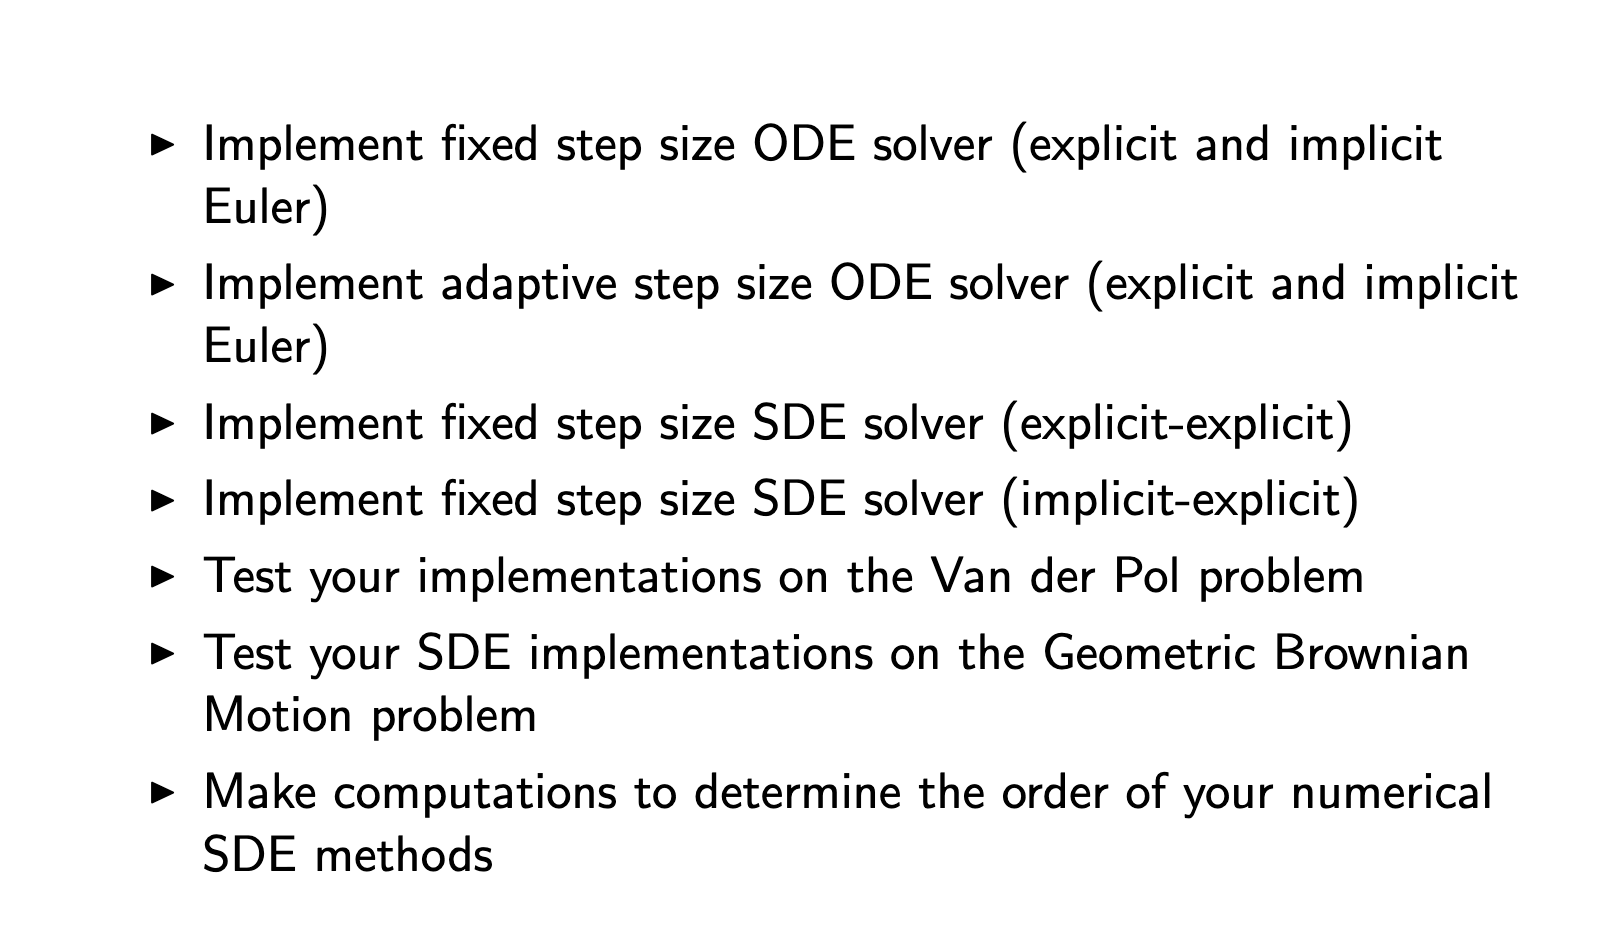

(10, 1000)


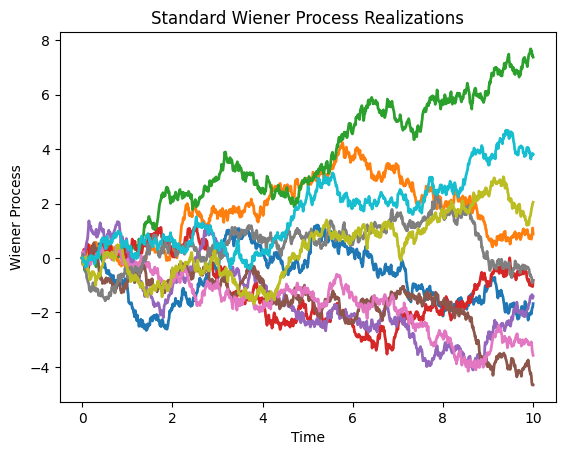

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def scalar_std_wiener_process(T, N, Ns, seed=None):
    """
    Generates Ns realizations of a standard scalar Wiener process.
    
    Parameters:
    T : float
        Final time.
    N : int
        Number of intervals.
    Ns : int
        Number of realizations.
    seed : int, optional
        Seed for the random number generator.
    
    Returns:
    W : ndarray
        Standard Wiener process in [0,T].
    Tw : ndarray
        Time points.
    dW : ndarray
        White noise used to generate the Wiener process.
    """
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(Ns, N)
    W = np.hstack((np.zeros((Ns, 1)), np.cumsum(dW, axis=1)))
    Tw = np.linspace(0, T, N + 1)
    
    return W, Tw, dW


def StdWienerProcess(T, N, nW, Ns, seed=None):
    """
    Generates Ns realizations of a standard Wiener process.
    
    Parameters:
    T    : Final time
    N    : Number of intervals
    nW   : Dimension of W(k)
    Ns   : Number of realizations
    seed : To set the random number generator (optional)
    
    Returns:
    W    : Standard Wiener process in [0,T]
    Tw   : Time points
    dW   : White noise used to generate the Wiener process
    """
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(nW, N, Ns)
    W = np.concatenate((np.zeros((nW, 1, Ns)), np.cumsum(dW, axis=1)), axis=1)
    Tw = np.linspace(0, T, N + 1)
    
    return W, Tw, dW

# Example usage
T, N, Ns, seed = 10, 1000, 10, 100
W, Tw, dW = scalar_std_wiener_process(T, N, Ns, seed)
print(dW.shape)
plt.plot(Tw, W.T, linewidth=2)
plt.xlabel("Time")
plt.ylabel("Wiener Process")
plt.title("Standard Wiener Process Realizations")
plt.show()


## Implement fixed step size SDE solver explicit-explicit

In [150]:
## import numpy as np

def SDEsolverExplicitExplicit(ffun, gfun, T, x0, W, *args):
    """
    Solves an SDE using an explicit-explicit Euler-Maruyama scheme.

    Parameters:
    ffun : function
        Drift function f(t, x, *args).
    gfun : function
        Diffusion function g(t, x, *args).
    T : ndarray
        Array of time points.
    x0 : ndarray
        Initial condition.
    W : ndarray
        Wiener process increments (same shape as T).
    *args : tuple
        Additional parameters for ffun and gfun.

    Returns:
    X : ndarray
        Solution of the SDE at end
    """
    # Number of timesteps
    N = len(T)
    # Number of dimensions of x
    nx = len(x0)
    # Allocating space for the solution 
    X = np.zeros((nx, N))
    # Storing the initial value in X
    X[:, 0] = x0


    for k in range(N - 1):
        # Timestep
        dt = T[k + 1] - T[k]
        # White noise 
        dW = W[:, k + 1] - W[:, k]
        
        # Evaluating the drift function
        f,_ = ffun(T[k], X[:, k], *args)
        
        # Evaluating the diffusion function
        g = gfun(T[k], X[:, k], *args)
        
        # SDE psi definition
        psi = X[:, k] + g * dW  

        # Explicit step to get Xk+1
        X[:, k + 1] = np.array(psi) + np.array(f) *np.array(dt)
    return X

def VanderpolDrift(t, x, p):
    mu = p[0]
    
    tmp = mu * (1.0 - x[0]**2)
    
    f = np.zeros(2)
    f[0] = x[1]
    f[1] = tmp * x[1] - x[0]
    
    if len(locals()) > 3:  # Check if we need the Jacobian matrix
        J = np.array([[0, 1], 
                      [-2 * mu * x[0] * x[1] - 1.0, tmp]])
        return f, J
    return f, []


def VanderPolDiffusion1(t, x, p):
    sigma = p[1]  # Assuming p is a list or numpy array
    g = np.array([0.0, sigma])
    return g



def VanderPolDiffusion1_(t, x, p):
    sigma = p[1]  # Extract sigma
    g = np.array([[0.0], [sigma]])  # Reshape to (2,1)
    return g



In [47]:
print(np.shape(W))
print(np.shape(T))

(10, 1001)
()


In [167]:

# Parameters
mu = 3
sigma = 0.5
x0 = np.array([0.5, 0.5])
p = np.array([mu, sigma])

tf = 5 * mu
nw = 2
N = 5000
Ns = 3
seed = 100


# Generate standard Wiener process 
#T, N, nW, Ns
W, T, dW = StdWienerProcess(tf, N,nw, Ns, seed)
print(W.shape)


# Initialize solution array
X = np.zeros((len(x0), N + 1, Ns))

# Solve SDE for each sample path
for i in range(Ns):
    X[:, :, i] = SDEsolverExplicitExplicit(
        VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, i], p
    )

# Solve deterministic case
Xd = SDEsolverExplicitExplicit(
    VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, i], np.array([mu, 0.0])
)

(2, 5001, 3)


In [91]:
X.shape
Xd.shape

(2, 5001)

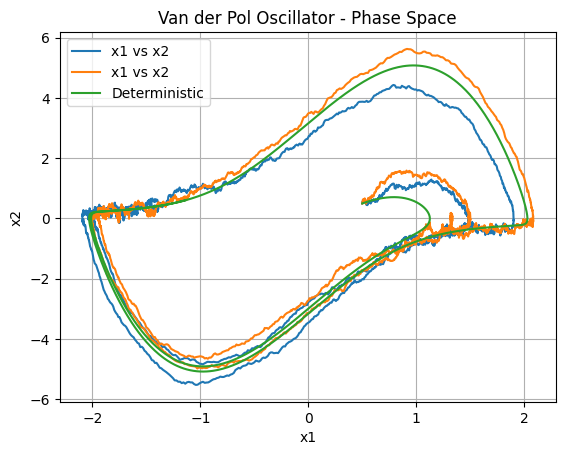

In [152]:
#plt.figure()
#plt.plot(T, Xd[:, 0], label='x1 (Position)')
#plt.plot(T, Xd[:, 1], label='x2 (Velocity)')
#plt.xlabel('Time')
#plt.ylabel('Values')
#plt.legend()
#plt.grid()
#plt.show()


plt.figure()
plt.plot(X[0,:, 0], X[1,:, 0], label='x1 vs x2')
plt.plot(X[0,:, 1], X[1,:, 1], label='x1 vs x2')
plt.plot(Xd[0,:,], Xd[1,:], label='Deterministic')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Van der Pol Oscillator - Phase Space')
plt.grid()
plt.show()





## Implement fixed step size SDE solver implicit-explicit

In [174]:
def SDEsolverImplicitExplicit(ffun, gfun, T, x0, W, *args):
    tol = 1.0e-8            # Tolerance
    maxit = 100             # Max iterations
    
    N = len(T)              # Time steps
    nx = len(x0)            # Dimensions of solution
    X = np.zeros((nx, N))   # Allocating space for solution over time
    X[:, 0] = x0            # Storing initial x in X
    
    for k in range(N - 1):
        # Evaluating the diffusion term
        g = gfun(T[k], X[:, k], *args)
        # Timestep
        dt = T[k + 1] - T[k]
        
        # Corresponding white noise
        dW = W[:, k + 1] - W[:, k]
        
        # SDE definition for psi
        psi = X[:, k] + g * dW

        # Evaluating the drift term
        f,_ = ffun(T[k], X[:, k], *args)

        # Using the explicit as initial guess
        xinit = np.array(psi) + np.array(f) * np.array(dt)

        # Implicit step
        X[:, k + 1] = SDENewtonSolver(
            ffun, T[k + 1], dt, psi, xinit, tol, maxit, *args
        )
    
    return X


def SDENewtonSolver(ffun, t, dt, psi, xinit, tol, maxit, *args):
    I = np.eye(len(xinit))      # Identity matrix size x
    x = xinit                   # Initial guess
    f, J = ffun(t, x, *args)    # Evaluating function for f val and jacobian
    R = x - f * dt - psi        # Residual function
    it = 1                      # Iteration count
    
    # While residual is larger than the tolerance
    while np.linalg.norm(R, np.inf) > tol and it <= maxit:
        # Jacobian of residual
        dRdx = I - J * dt   
        # Change in x
        mdx = np.linalg.solve(dRdx, R)
        # Update x
        x = x - mdx
        # Compute function value and jacobian
        f, J = ffun(t, x, *args)
        # Residual
        R = x - f * dt - psi
        # Iteration count
        it += 1
    
    return x

In [175]:

# Van der Pol parameter
mu = 3
# Noise value
sigma = 0.5
# Parameters
p = np.array([mu, sigma])
# Initial value 
x0 = np.array([0.5, 0.5])

# Time frame
tf = 5 * mu
# Dimensions of W(k)
nw = 2
# Number of intervals
N = 5000
# Number of realizations
Ns = 5
# Reproducability
seed = 100

# Generate standard Wiener process
W, T, dW = StdWienerProcess(tf, N,nw ,Ns, seed)
# Initialize solution array
X = np.zeros((len(x0), N + 1, Ns))

# Solve SDE for each sample path
for i in range(Ns):
    X[:, :, i] = SDEsolverImplicitExplicit(
        VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, i], p
    )


# Solve deterministic case
Xd = SDEsolverImplicitExplicit(
    VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, i], np.array([mu, 0.0])
)


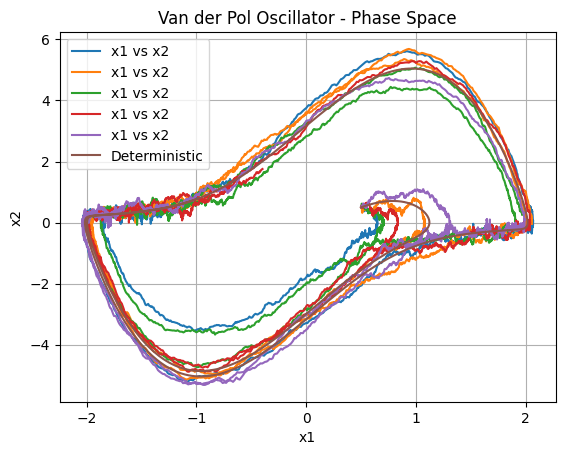

In [169]:

plt.figure()
plt.plot(X[0,:, 0], X[1,:, 0], label='x1 vs x2')
plt.plot(X[0,:, 1], X[1,:, 1], label='x1 vs x2')
plt.plot(X[0,:, 2], X[1,:, 2], label='x1 vs x2')
plt.plot(X[0,:, 3], X[1,:, 3], label='x1 vs x2')
plt.plot(X[0,:, 4], X[1,:, 4], label='x1 vs x2')

plt.plot(Xd[0,:,], Xd[1,:], label='Deterministic')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Van der Pol Oscillator - Phase Space')
plt.grid()
plt.show()


Geometric Browninan